In [11]:

from sklearn.preprocessing import MinMaxScaler
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:


# Analysis input data - cooling

# 1 min data (5 features): Room temperature, CO2, Humidity, Ambient air temperature, Window 

# 8h data (5 features) : weekend, hourmin, rst, performance, mode



In [3]:
df_tr_1min = pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_1Min_Train_Jan_Sept_cool.csv')

df_tr_8h = pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_8h_T_Train_Jan_Sept_cool.csv')


In [4]:
df_val_1min =pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_1Min_Val_Jan_Sept_cool.csv')

df_val_8h = pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_8h_T_Val_Jan_Sept_cool.csv')

In [5]:
df_te_1min =pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_1Min_Test_Jan_Sept_cool.csv')

df_te_8h = pd.read_csv('/Users/annaclara/Documents/E3D/DL-EN/CNN/Data/75_Weekend/cool/Room_75_8h_T_Test_Jan_Sept_cool.csv')

In [6]:

# transform timestamp to date time format and eliminate not used columns
def prepare_preproc(X_8h_input, X_1min_input):
    X_8h = X_8h_input.drop(columns='Unnamed: 0')
    X_8h = X_8h.drop(columns= X_8h.filter(regex='_2$|_3$|_4$|_5$|_6$|_7$|_8$').columns)
    X_1m  = X_1min_input.drop(columns='Unnamed: 0')
# Transform timestamp column into datetime, removing timezone info  (transform it to strings, select datetime info and transform it to datetime)
    X_8h['timestamp'] = X_8h['timestamp'].astype(str)
    X_1m['timestamp'] = X_1m['timestamp'].astype(str)
# Remove the last 6 characters (timezone information) from the timestamp strings
    X_8h['timestamp'] = X_8h['timestamp'].str[:-6]
    X_1m['timestamp'] = X_1m['timestamp'].str[:-6]
# Transform to datetime
    X_8h['timestamp'] = pd.to_datetime(X_8h['timestamp'])
    X_1m['timestamp'] = pd.to_datetime(X_1m['timestamp'])
# Remove columns
    X_1m = X_1m.iloc[:,0:6] # timestamp, Room temperature, CO2, Humidity, Ambient air temperature, Window  (Timestamp is necessary to update HourMin column afterwards)
    X_8h = X_8h.iloc[:,0:8] # timestamp, monthday, dayofweek, weekend, hourmin, RST, performance, mode
    X_8h = X_8h.drop(columns=X_8h.iloc[:,1:3]) # timestamp, weekend, hourmin, rst, performance, mode
    return X_1m, X_8h




In [7]:
X_tr_1min, X_tr_8h = prepare_preproc(df_tr_8h, df_tr_1min)
X_val_1min, X_val_8h = prepare_preproc(df_val_8h, df_val_1min)
X_te_1min, X_te_8h = prepare_preproc(df_te_8h, df_te_1min)

In [8]:
def PrepareInput(Xtr_1, X_tr_8h):

    num_samples = (Xtr_1.shape[0] // 720) * 660
    n_steps = 60
    n_features=10
    X_train = []

    idx_remove_init = [15, 16, 17, 18, 19]
    idx_remove=[15, 16, 17, 18, 19]
    for i in range(1,59):
                for j in idx_remove_init:
                    idx = j + (10 * i) 
                    idx_remove.append(idx)

    mask = np.ones(n_steps*n_features, dtype=bool)
    mask[idx_remove] = False
    
    add_col_seq_x = Xtr_1.shape[1] + 1
    add_col_seq_x_end = Xtr_1.shape[1] + X_tr_8h.shape[1]
    
    k = 0
    j = np.arange(0, Xtr_1.shape[0], 720) # j0 #gets everyday 5am
    for w in range(len(j)): #w0
        a = j[w] #j0
        for i in range(a, a + (719 - n_steps) + 1): #i=j0=0
            seq_x = Xtr_1.iloc[i:i+n_steps, :] # takes timestep t-59 in the first row and t in the last
            hour_min  =pd.to_datetime(seq_x['timestamp']).dt.hour + (pd.to_datetime(seq_x['timestamp']).dt.minute/ 60)
            new_columns_data = X_tr_8h.iloc[k, :].values
    
            # Reshape new_columns_data to have the same number of rows as seq_x, copying values from new_columns_data
            new_columns_data = np.tile(new_columns_data, (seq_x.shape[0], 1))

            # update hour_min to consider 5am timestamps
            seq_x_with_new_columns = np.concatenate((seq_x, new_columns_data), axis=1)
            seq_x_with_new_columns[:,8] = hour_min
            # delete timestamp columns
            seq_x_with_new_columns = np.delete(seq_x_with_new_columns, 6, axis=1)
            seq_x_with_new_columns = np.delete(seq_x_with_new_columns, 0, axis=1)
            idx = np.argsort(-seq_x_with_new_columns[:, 6]) # get sorted indexes
            seq_x_with_new_columns_sorted=seq_x_with_new_columns[idx]
            seq_x_flattened = seq_x_with_new_columns_sorted.flatten()
            seq_x_mask = seq_x_flattened[mask] # the mask removes the 8h from the flattening (only 1min data repeats)
            seq_x_ready = seq_x_mask.T.reshape(-1, seq_x_mask.shape[0])

            # Append to x list
            X_train.append(seq_x_ready)

            k += 1 #k=1
    X_stacked = np.vstack(X_train)
    return X_stacked



In [9]:
x_tr = PrepareInput(X_tr_1min, X_tr_8h)
x_val = PrepareInput(X_val_1min, X_val_8h)
x_te = PrepareInput(X_te_1min, X_te_8h)



In [12]:
# normalise
scaler = MinMaxScaler()
x_tr_n = scaler.fit_transform(x_tr)
x_val_n = scaler.transform(x_val)
x_te_n = scaler.transform(x_te)

In [14]:
# Create a dictionary to store all the lists
data = {'X_tr_n': x_tr_n, 'X_val_n': x_val_n, 'X_te_n': x_te_n}

# Specify the file path
file_path = 'lists_data_MLP.pkl'

# Open the file in binary write mode
with open(file_path, 'wb') as f:
    # Use pickle to dump the data dictionary into the file
    pickle.dump(data, f)

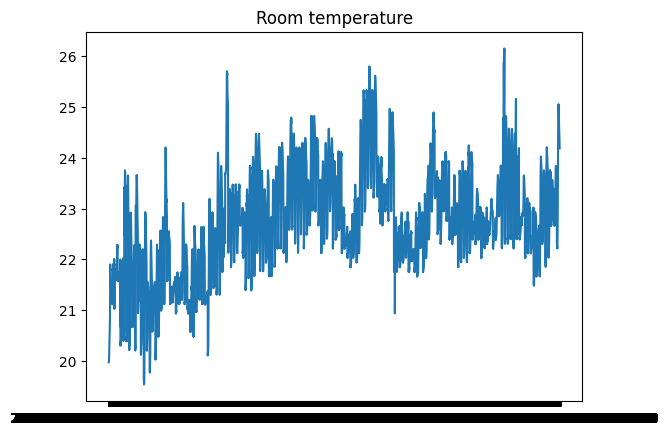

In [2]:
plt.figure(dpi=600)
plt.plot(df_1min.iloc[:,1], df_1min.iloc[:,2])
plt.title('Room temperature')
plt.show()

In [17]:
x_tr_n.shape[1]

305